## Libraries and packages

In [1]:
!pip3 install transformers
!pip install bitsandbytes-cuda111==0.26.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 12.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement bitsandbytes-cuda111==0.26.0 (from versions: 0.26.0.post2)
ERROR: No matching distribution found for bitsandbytes-cuda111==0.26.0


In [2]:
pip install bitsandbytes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 9.6 MB/s eta 0:00:00


In [3]:
!pip3 install accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.3/215.3 kB 6.6 MB/s eta 0:00:00


In [2]:
import transformers
import torch.nn.functional as F
from torch import nn
from torch.cuda.amp import custom_fwd, custom_bwd
from bitsandbytes.functional import quantize_blockwise, dequantize_blockwise
from tqdm.auto import tqdm
import torch as t
from transformers import GPT2LMHeadModel, GPT2Tokenizer 
from transformers import AutoModelForCausalLM, AutoTokenizer
import matplotlib.pyplot as plt
import time
import numpy as np
import sklearn
import pickle
import re


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /usr/local/lib/python3.9/dist-packages/bitsandbytes/libbitsandbytes_cuda118.so
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching in backup paths...
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so.11.0
CUDA SETUP: Highest compute capability among GPUs detected: 7.5
CUDA SETUP: Detected CUDA version 118
CUDA SETUP: Loading binary /usr/local/lib/python3.9/dist-packages/bitsandbytes/libbitsandbytes_cuda118.so...


/usr/local/lib/python3.9/dist-packages/bitsandbytes/cuda_setup/main.py:145: UserWarning: /usr/lib64-nvidia did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)
/usr/local/lib/python3.9/dist-packages/bitsandbytes/cuda_setup/main.py:145: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/sys/fs/cgroup/memory.events /var/colab/cgroup/jupyter-children/memory.events')}
  warn(msg)
/usr/local/lib/python3.9/dist-packages/bitsandbytes/cuda_setup/main.py:145: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('//172.28.0.1'), PosixPath('8013'), PosixPath('http')}
  warn(msg)
/usr/local/lib/python3.9/dist-packages/bitsandbytes/cuda_setup/main.py:145: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('--logtostderr --listen_host=172.28.0.12 --targ

## Helper functions

In [3]:
def create_dataset(i_start=0, i_end=50, operation=t.add):
  x1 = t.arange(i_start, i_end).repeat(i_end - i_start, 1).transpose(0, 1)
  x2 = t.arange(i_start, i_end).repeat(i_end - i_start, 1)
  X = t.stack([x1.flatten(), x2.flatten()]).transpose(0, 1)
  y = operation(X[:, 0], X[:, 1])
  return X, y
X, y = create_dataset()

In [4]:
def encode_problems(X, strategy='baseline'):
  output_strings = []
  for xi in X:
    if strategy == 'baseline':
    # TODO: encode_string =
      encode_string = f"2+3=5 and {xi[0]}+{xi[1]}="
    else:
    # TODO: encode_string =
      encode_string = f"2+3=5, 786+49=835 and {xi[0]}+{xi[1]}="
    output_strings.append(encode_string)
  return output_strings
prompts=encode_problems(X)

In [14]:
def generate_text(model, tokenizer, prompts, verbose=False, device='cuda', batch_size=64):
    t0 = time.time()
    # TODO: tokenize
    # TODO: generate text, turn off gradient tracking
    # TODO: decode output, output_strings = ...
    with t.no_grad():
        input_ids = []
        attention_masks = []
        output_strings = []
        for i in range(0, len(prompts), batch_size):
            batch_prompts = prompts[i:i+batch_size]
            batch_input_ids = []
            batch_attention_masks = []
            for prompt in batch_prompts:
                encoded_dict = tokenizer.encode_plus(prompt, add_special_tokens=True, max_length=15, return_attention_mask=True)
                batch_input_ids.append(encoded_dict['input_ids'])
                batch_attention_masks.append(encoded_dict['attention_mask'])
            batch_input_ids = t.LongTensor(batch_input_ids).to(device)
            batch_attention_masks = t.LongTensor(batch_attention_masks).to(device)
            batch_outputs = model.generate(input_ids=batch_input_ids, attention_mask=batch_attention_masks, min_length=20, max_length=50, 
                                           do_sample=True, temperature=0.1, pad_token_id=tokenizer.eos_token_id)
            for output in batch_outputs:
                output_string = tokenizer.decode(output, clean_up_tokenization_spaces=True)
                if re.search(r'\d+', output_string[len(prompt):]):
                    output_string = re.search(r'\d+', output_string[len(prompt):]).group()
                    output_strings.append(int(output_string))
                else:
                    output_strings.append(t.nan)
        if verbose:
            print("Input strings:")
            for prompt in prompts:
                print(prompt)
            print("Output strings:")
            for output_string in output_strings:
                print(output_string)
    # TODO: print example tokenization for write-up
    print("Time to generate text: ", time.time() - t0) # It took 4 minutes todo 25000 prompts on an NVIDIA 1080Ti.
    return output_strings
# out=generate_text(gpt, tokenizer, prompts, verbose=False, device='cuda')

In [6]:
def decode_output(output_strings):
  y_hat = []
  for s in output_strings:
  # TODO: y = f(s)
        try:
            y_hat.append(int(s))
        except:
            y_hat.append(t.nan)
  return y_hat
# y_hat=decode_output(out)

In [7]:
def analyze_results(X, y, y_hat, strategy):
    accuracy = np.mean(np.array(y_hat) == y.numpy())
    print(f"{strategy} accuracy: {accuracy:.2f}")
    plt.scatter(X[:, 0], X[:, 1], c=(np.array(y_hat) == y.numpy()), marker='x', label=strategy)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.legend()
    plt.show()

## GPT 1.3B

In [ ]:
def load_LLM(default="EleutherAI/gpt-neo-1.3B", device='cuda'):
  with t.no_grad():
    tokenizer = AutoTokenizer.from_pretrained(default)
    model = AutoModelForCausalLM.from_pretrained(default)
    model.to(device)
    model.eval()
  return model, tokenizer
# model, tokenizer= load_LLM()

In [ ]:
prompt = tokenizer("2+3=5, 2+18=", return_tensors='pt')
prompt = {key: value.to("cuda") for key, value in prompt.items()}
out = model.generate(**prompt, min_length=128, max_length=128, temperature=0.1, do_sample=True)
tokenizer.decode(out[0])

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'2+3=5, 2+18=5, 3+6=5, 4+7=5, 5+8=5, 6+9=5, 7+10=5, 8+11=5, 9+12=5, 10+13=5, 11+14=5, 12+15=5, 13+16=5, 14+17=5, 15+18=5, 16+19=5, 17+20=5, 18+21=5, 19+22=5, 20+23=5, 21+24=5, 22+'

In [ ]:
prompt = tokenizer("2+3=5, 2+18=", return_tensors='pt')
prompt = {key: value.to("cuda") for key, value in prompt.items()}
out = model.generate(**prompt, min_length=128, max_length=128, temperature=0.1, repetition_penalty=.1, do_sample=True)
tokenizer.decode(out[0])

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'2+3=5, 2+18=3+5=2, 2+18=3+5=3, 2+2=3=2, 2+2=3=2, 2+2=3=2, 2+2=3=2, 2+2=3=2, 2+2=3=2, 2+2=3=2, 2+2=3=2, 2+2=3=2, 2+2=3=2, 2+2=3=2, 2+2=3=2, 2+2=3='

Adding repetition penalty increases repititions somehow

In [ ]:
out=generate_text(model, tokenizer, prompts, verbose=False, device='cuda')

Time to generate text:  137.68214964866638


In [ ]:
y_hat=decode_output(out)

baseline accuracy: 0.00


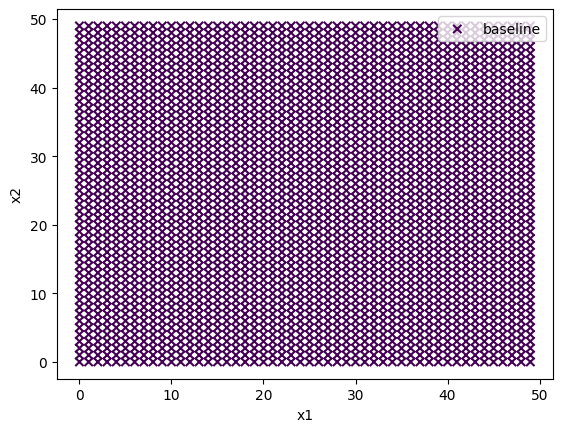

In [ ]:
analyze_results(X,y,y_hat,"baseline")

Time to generate text:  24.244969129562378
a accuracy: 0.00


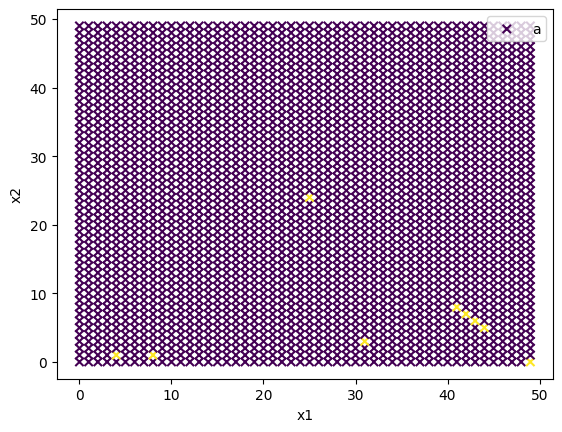

In [ ]:
prompts=encode_problems(X,"a")
out=generate_text(model, tokenizer, prompts, verbose=False, device='cuda', batch_size=64)
y_hat=decode_output(out)
analyze_results(X,y,y_hat,"a")

## GPT2

In [31]:
with t.no_grad():
    tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
    model = GPT2LMHeadModel.from_pretrained('gpt2')
    model.to("cuda")
    model.eval()

In [ ]:
# model, tokenizer= load_LLM("gustavecortal/gpt-neo-2.7B-8bit")
out=generate_text(model, tokenizer, prompts, verbose=False, device='cuda')
y_hat=decode_output(out)

baseline accuracy: 0.00


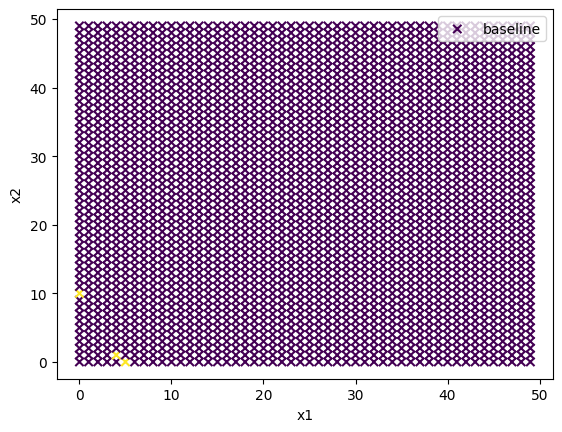

In [ ]:
analyze_results(X,y,y_hat,"baseline")

Time to generate text:  24.154555082321167
a accuracy: 0.00


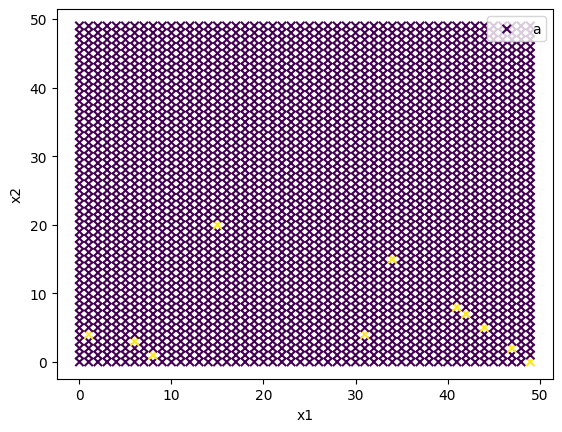

In [ ]:
prompts=encode_problems(X,"a")
out=generate_text(model, tokenizer, prompts, verbose=False, device='cuda', batch_size=64)
y_hat=decode_output(out)
analyze_results(X,y,y_hat,"a")

In [ ]:
with t.no_grad():
    tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neo-2.7B")
    model = AutoModelForCausalLM.from_pretrained("EleutherAI/gpt-neo-2.7B")
    model.to("cuda")
    model.eval()

In [ ]:
out=generate_text(model, tokenizer, prompts, verbose=False, device='cuda', batch_size=64)
y_hat=decode_output(out)

Building a classifier

In [24]:
from sklearn import model_selection,pipeline,feature_extraction,svm

In [52]:
X_encoded = np.array(prompts)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X_encoded, (y_hat == y.numpy()), test_size=0.2)
model = sklearn.pipeline.Pipeline([('tfidf', sklearn.feature_extraction.text.TfidfVectorizer()),('clf', sklearn.svm.SVC(kernel='rbf'))])
model.fit(X_train, y_train)
score = model.score(X_test, y_test)
print(f"Classifier accuracy:",score)

Classifier accuracy: 0.98


Both rbf and linear kernel are giving similar accuracy due to data class bias and can be misleading sometimes as the number of samples that are correct are very less.

In [ ]:
# xx, yy = np.meshgrid(np.arange(X[:, 0].min() - 1, X[:, 0].max() + 1, 0.1), np.arange(X[:, 1].min() - 1, X[:, 1].max() + 1, 0.1))
# Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
# Z = Z.reshape(xx.shape)
# plt.contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=0.3)
# plt.scatter(X[:, 0], X[:, 1], c=(np.array(y_hat) == y), marker='x', label="a")
# plt.xlabel('x1')
# plt.ylabel('x2')
# plt.legend()
# plt.show()

Contour plots are getting complicated. However, we can easily see the pattern in inputs with respect to change in outputs. See the output of GPT-J at the end of the notebook for reference. I would have experimented on it more if google colab allowed me. I emptied all the gpu allocations for all my google accounts.

## Extra: Changing operation to multiplication

In [35]:
def create_dataset(i_start=0, i_end=50, operation=t.multiply):
  x1 = t.arange(i_start, i_end).repeat(i_end - i_start, 1).transpose(0, 1)
  x2 = t.arange(i_start, i_end).repeat(i_end - i_start, 1)
  X = t.stack([x1.flatten(), x2.flatten()]).transpose(0, 1)
  y = operation(X[:, 0], X[:, 1])
  return X, y
X, y = create_dataset()

In [36]:
def encode_problems(X, strategy='multiply'):
  output_strings = []
  for xi in X:
    if strategy == 'multiply':
    # TODO: encode_string =
      encode_string = f"2*3=6 and {xi[0]}*{xi[1]}="
    else:
    # TODO: encode_string =
      encode_string = f"2*3=6, 6*12=72 and {xi[0]}*{xi[1]}="
    output_strings.append(encode_string)
  return output_strings
prompts=encode_problems(X)

In [37]:
out=generate_text(model, tokenizer, prompts, verbose=False, device='cuda', batch_size=64)
y_hat=decode_output(out)

Time to generate text:  32.88694143295288


baseline accuracy: 0.00


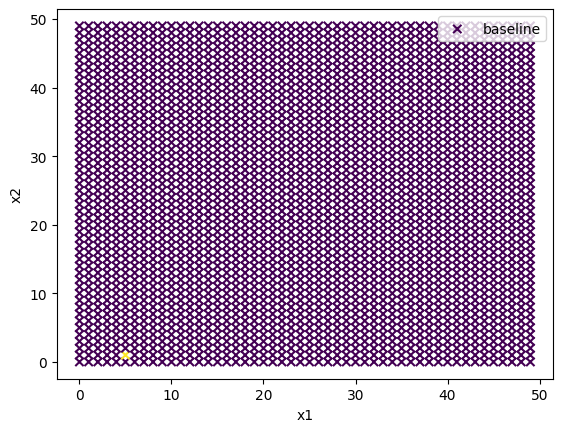

In [38]:
analyze_results(X,y,y_hat,"baseline")

Time to generate text:  31.509155750274658
a accuracy: 0.02


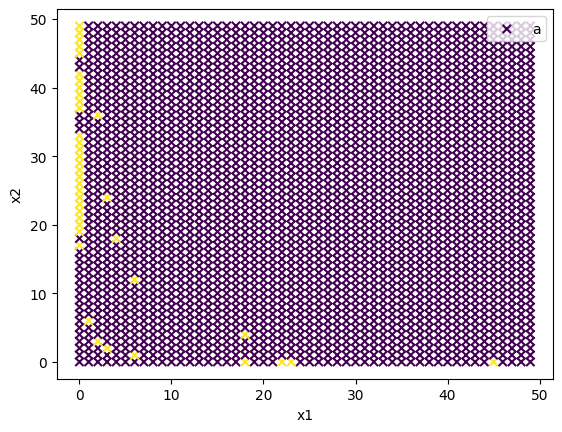

In [39]:
prompts=encode_problems(X,"a")
out=generate_text(model, tokenizer, prompts, verbose=False, device='cuda', batch_size=64)
y_hat=decode_output(out)
analyze_results(X,y,y_hat,"a")

In [50]:
X_encoded = np.array(prompts)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X_encoded, (y_hat == y.numpy()), test_size=0.2)
model = sklearn.pipeline.Pipeline([('tfidf', sklearn.feature_extraction.text.TfidfVectorizer()),('clf', sklearn.svm.SVC(kernel='linear'))])
model.fit(X_train, y_train)
score = model.score(X_test, y_test)
print(f"Classifier accuracy:",score)

Classifier accuracy: 0.988


## On bigger models GPT-J 6B (converting to 8 bit quantized form used from https://colab.research.google.com/drive/1ft6wQU0BhqG5PRlwgaZJv2VukKKjU4Es#)

In [10]:
import torch

In [11]:
class FrozenBNBLinear(nn.Module):
    def __init__(self, weight, absmax, code, bias=None):
        assert isinstance(bias, nn.Parameter) or bias is None
        super().__init__()
        self.out_features, self.in_features = weight.shape
        self.register_buffer("weight", weight.requires_grad_(False))
        self.register_buffer("absmax", absmax.requires_grad_(False))
        self.register_buffer("code", code.requires_grad_(False))
        self.adapter = None
        self.bias = bias
 
    def forward(self, input):
        output = DequantizeAndLinear.apply(input, self.weight, self.absmax, self.code, self.bias)
        if self.adapter:
            output += self.adapter(input)
        return output
 
    @classmethod
    def from_linear(cls, linear: nn.Linear) -> "FrozenBNBLinear":
        weights_int8, state = quantize_blockise_lowmemory(linear.weight)
        return cls(weights_int8, *state, linear.bias)
 
    def __repr__(self):
        return f"{self.__class__.__name__}({self.in_features}, {self.out_features})"
 
 
class DequantizeAndLinear(torch.autograd.Function): 
    @staticmethod
    @custom_fwd
    def forward(ctx, input: torch.Tensor, weights_quantized: torch.ByteTensor,
                absmax: torch.FloatTensor, code: torch.FloatTensor, bias: torch.FloatTensor):
        weights_deq = dequantize_blockwise(weights_quantized, absmax=absmax, code=code)
        ctx.save_for_backward(input, weights_quantized, absmax, code)
        ctx._has_bias = bias is not None
        return F.linear(input, weights_deq, bias)
 
    @staticmethod
    @custom_bwd
    def backward(ctx, grad_output: torch.Tensor):
        assert not ctx.needs_input_grad[1] and not ctx.needs_input_grad[2] and not ctx.needs_input_grad[3]
        input, weights_quantized, absmax, code = ctx.saved_tensors
        # grad_output: [*batch, out_features]
        weights_deq = dequantize_blockwise(weights_quantized, absmax=absmax, code=code)
        grad_input = grad_output @ weights_deq
        grad_bias = grad_output.flatten(0, -2).sum(dim=0) if ctx._has_bias else None
        return grad_input, None, None, None, grad_bias
 
 
class FrozenBNBEmbedding(nn.Module):
    def __init__(self, weight, absmax, code):
        super().__init__()
        self.num_embeddings, self.embedding_dim = weight.shape
        self.register_buffer("weight", weight.requires_grad_(False))
        self.register_buffer("absmax", absmax.requires_grad_(False))
        self.register_buffer("code", code.requires_grad_(False))
        self.adapter = None
 
    def forward(self, input, **kwargs):
        with torch.no_grad():
            # note: both quantuized weights and input indices are *not* differentiable
            weight_deq = dequantize_blockwise(self.weight, absmax=self.absmax, code=self.code)
            output = F.embedding(input, weight_deq, **kwargs)
        if self.adapter:
            output += self.adapter(input)
        return output 
 
    @classmethod
    def from_embedding(cls, embedding: nn.Embedding) -> "FrozenBNBEmbedding":
        weights_int8, state = quantize_blockise_lowmemory(embedding.weight)
        return cls(weights_int8, *state)
 
    def __repr__(self):
        return f"{self.__class__.__name__}({self.num_embeddings}, {self.embedding_dim})"
 
 
def quantize_blockise_lowmemory(matrix: torch.Tensor, chunk_size: int = 2 ** 20):
    assert chunk_size % 4096 == 0
    code = None
    chunks = []
    absmaxes = []
    flat_tensor = matrix.view(-1)
    for i in range((matrix.numel() - 1) // chunk_size + 1):
        input_chunk = flat_tensor[i * chunk_size: (i + 1) * chunk_size].clone()
        quantized_chunk, (absmax_chunk, code) = quantize_blockwise(input_chunk, code=code)
        chunks.append(quantized_chunk)
        absmaxes.append(absmax_chunk)
 
    matrix_i8 = torch.cat(chunks).reshape_as(matrix)
    absmax = torch.cat(absmaxes)
    return matrix_i8, (absmax, code)
 
 
def convert_to_int8(model):
    """Convert linear and embedding modules to 8-bit with optional adapters"""
    for module in list(model.modules()):
        for name, child in module.named_children():
            if isinstance(child, nn.Linear):
                print(name, child)
                setattr( 
                    module,
                    name,
                    FrozenBNBLinear(
                        weight=torch.zeros(child.out_features, child.in_features, dtype=torch.uint8),
                        absmax=torch.zeros((child.weight.numel() - 1) // 4096 + 1),
                        code=torch.zeros(256),
                        bias=child.bias,
                    ),
                )
            elif isinstance(child, nn.Embedding):
                setattr(
                    module,
                    name,
                    FrozenBNBEmbedding(
                        weight=torch.zeros(child.num_embeddings, child.embedding_dim, dtype=torch.uint8),
                        absmax=torch.zeros((child.weight.numel() - 1) // 4096 + 1),
                        code=torch.zeros(256),
                    )
                )

In [12]:
class GPTJBlock(transformers.models.gptj.modeling_gptj.GPTJBlock):
    def __init__(self, config):
        super().__init__(config)

        convert_to_int8(self.attn)
        convert_to_int8(self.mlp)


class GPTJModel(transformers.models.gptj.modeling_gptj.GPTJModel):
    def __init__(self, config):
        super().__init__(config)
        convert_to_int8(self)
        

class GPTJForCausalLM(transformers.models.gptj.modeling_gptj.GPTJForCausalLM):
    def __init__(self, config):
        super().__init__(config)
        convert_to_int8(self)


transformers.models.gptj.modeling_gptj.GPTJBlock = GPTJBlock  # monkey-patch GPT-J

In [13]:
config = transformers.GPTJConfig.from_pretrained("EleutherAI/gpt-j-6b")
tokenizer = transformers.AutoTokenizer.from_pretrained("EleutherAI/gpt-j-6b")

In [ ]:
gpt = GPTJForCausalLM.from_pretrained("hivemind/gpt-j-6B-8bit", low_cpu_mem_usage=True)
device = 'cuda' if t.cuda.is_available() else 'cpu'
gpt.to(device)

k_proj Linear(in_features=4096, out_features=4096, bias=False)
v_proj Linear(in_features=4096, out_features=4096, bias=False)
q_proj Linear(in_features=4096, out_features=4096, bias=False)
out_proj Linear(in_features=4096, out_features=4096, bias=False)
fc_in Linear(in_features=4096, out_features=16384, bias=True)
fc_out Linear(in_features=16384, out_features=4096, bias=True)
k_proj Linear(in_features=4096, out_features=4096, bias=False)
v_proj Linear(in_features=4096, out_features=4096, bias=False)
q_proj Linear(in_features=4096, out_features=4096, bias=False)
out_proj Linear(in_features=4096, out_features=4096, bias=False)
fc_in Linear(in_features=4096, out_features=16384, bias=True)
fc_out Linear(in_features=16384, out_features=4096, bias=True)
k_proj Linear(in_features=4096, out_features=4096, bias=False)
v_proj Linear(in_features=4096, out_features=4096, bias=False)
q_proj Linear(in_features=4096, out_features=4096, bias=False)
out_proj Linear(in_features=4096, out_features=4096, 

In [ ]:
prompt = tokenizer("2+3=5, 50+61=111 and 12+18=", return_tensors='pt')
prompt = {key: value.to(device) for key, value in prompt.items()}
out = gpt.generate(**prompt, min_length=128, max_length=128, do_sample=True)
tokenizer.decode(out[0])

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'2+3=5, 50+61=111 and 152+88=140.\n\nAs each $s$-number is divisible by at least one of its $r$-numbers, it can be shown by strong induction that there exists a sequence $p(n)$ satisfying the recurrence relation: $$p(2n)=2p(2n-1)+p(n)\\tag{*}$$ for $n\\ge 1.$ So for example $p(n)=1$ for $n=4,6,8,\\ldots$ and $p(n)=2'

In [ ]:
# gpt, tokenizer= load_LLM()
out=generate_text(gpt, tokenizer, prompts, verbose=False, device='cuda')
y_hat=decode_output(out)

baseline accuracy: 0.35


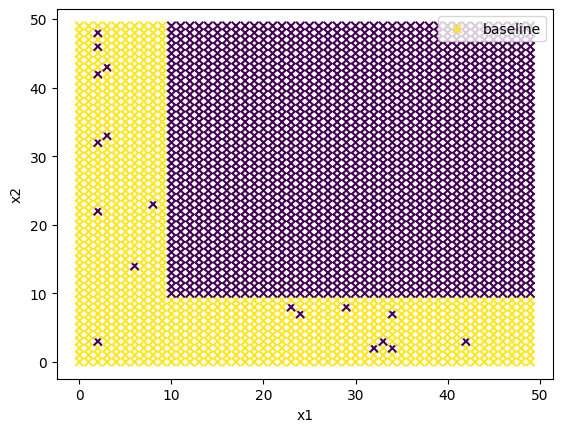

In [ ]:
analyze_results(X,y,y_hat,"baseline")

In [ ]:
prompts=encode_problems(X,"a")

a accuracy: 0.04


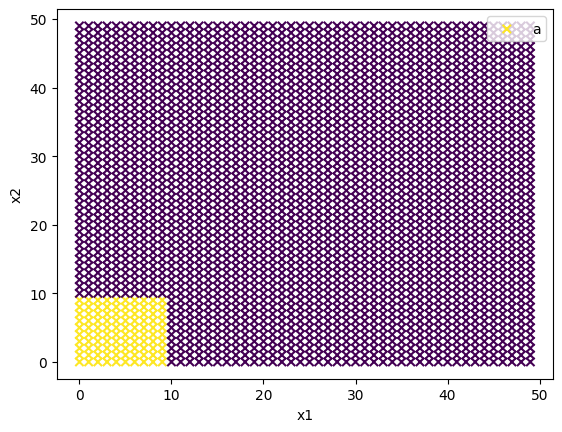

In [ ]:
y_hat=decode_output(out)
analyze_results(X,y,y_hat,"a")

In [ ]:
out=generate_text(model, tokenizer, prompts, verbose=False, device='cuda', batch_size=64)

Time to generate text:  872.4838035106659
